### Loss Log

| No. | Model                                           | Train Loss | Dev Loss |
| --- | ----------------------------------------------- | ---------- | -------- |
| 1   | NN v3 - 3 char context, 200 hidden, 12K params                       | 2.062      | 2.106    |
| 2   | Context Change: 8 char context, 200 hidden, 22K params                  | 1.932      | 2.035    |
| 3   | Flat -> Hierarchical: 8 char context, 200 hidden, 22K params                  | 1.949      | 2.029    |

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

torch.manual_seed(42)

%matplotlib inline

In [15]:
BLOCK_SIZE = 8
N_EMBED = 10
N_HIDDEN = 200
N_EPOCHS = 200000
BATCH_SIZE = 32
g = torch.Generator().manual_seed(2147483647)

In [16]:
def createWordsMapping(filename = 'names.txt'):
  words = open(filename, 'r').read().splitlines()
  chars = sorted(list(set(''.join(words))))
  stoi = {s:i+1 for i,s in enumerate(chars)}
  stoi['.'] = 0
  itos = {i:s for s,i in stoi.items()}
  n_vocab = len(stoi)
  return words, stoi, itos, n_vocab

def buildDataset(words, stoi, block_size):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

def buildDatasets(words, stoi, block_size):
  random.seed(42)
  random.shuffle(words)
  
  n1 = int(0.8 * len(words))
  n2 = int(0.9 * len(words))
  
  Xtr, Ytr = buildDataset(words[:n1], stoi, block_size)
  Xdev, Ydev = buildDataset(words[n1:n2], stoi, block_size)
  Xte, Yte = buildDataset(words[n2:], stoi, block_size)

  return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [17]:
words, stoi, itos, n_vocab = createWordsMapping()
Xtr, Ytr, Xdev, Ydev, Xte, Yte = buildDatasets(words, stoi, BLOCK_SIZE)
n_embed, n_hidden, block_size, n_epochs, batch_size = N_EMBED, N_HIDDEN, BLOCK_SIZE, N_EPOCHS, BATCH_SIZE
X, Y = Xtr, Ytr

In [18]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)/ fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdims=True)
      xvar = x.var(0, keepdims=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum *xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []
  
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
class FalttenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B,T,C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []
  
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [19]:
def initializeWeights(n_vocab, block_size, n_embed, n_hidden):
    
  model = Sequential([
    Embedding(n_vocab, n_embed),
    FalttenConsecutive(block_size),
    Linear(n_embed*block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_vocab)
  ])

  with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Make last layer less confident
  
  parameters = model.parameters()
  for p in parameters:
    p.requires_grad = True

  print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')
  return model

model = initializeWeights(n_vocab, BLOCK_SIZE, N_EMBED, N_HIDDEN)

Total Parameters: 22097


---

In [20]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)

print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0, 16,  5, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 15, 19,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [21]:
print(model.layers[0].out.shape) # output of embedding layer
model.layers[0].out[0]

torch.Size([4, 8, 10])


tensor([[ 1.1428, -0.0059,  0.3342,  1.3584, -0.9938,  1.4082,  1.0748, -0.2850,
          0.5397,  1.6047],
        [ 1.1428, -0.0059,  0.3342,  1.3584, -0.9938,  1.4082,  1.0748, -0.2850,
          0.5397,  1.6047],
        [ 1.1428, -0.0059,  0.3342,  1.3584, -0.9938,  1.4082,  1.0748, -0.2850,
          0.5397,  1.6047],
        [ 1.1428, -0.0059,  0.3342,  1.3584, -0.9938,  1.4082,  1.0748, -0.2850,
          0.5397,  1.6047],
        [ 1.1428, -0.0059,  0.3342,  1.3584, -0.9938,  1.4082,  1.0748, -0.2850,
          0.5397,  1.6047],
        [-1.5926, -0.8196,  0.7568,  0.2921, -0.8154,  1.7449, -0.0380, -2.1266,
         -1.0751,  1.5753],
        [ 0.8713,  0.7700,  0.3684, -0.7939, -2.9684,  0.2638,  0.4108, -1.4492,
          1.3606,  0.0959],
        [ 0.2819,  0.7550, -0.1216,  1.4171, -0.4111,  1.1039, -0.6529,  0.2741,
         -1.6033, -1.1177]], grad_fn=<SelectBackward0>)

In [22]:
print(model.layers[1].out.shape) # output of Flatten layer
model.layers[1].out[0]

torch.Size([4, 80])


tensor([ 1.1428, -0.0059,  0.3342,  1.3584, -0.9938,  1.4082,  1.0748, -0.2850,
         0.5397,  1.6047,  1.1428, -0.0059,  0.3342,  1.3584, -0.9938,  1.4082,
         1.0748, -0.2850,  0.5397,  1.6047,  1.1428, -0.0059,  0.3342,  1.3584,
        -0.9938,  1.4082,  1.0748, -0.2850,  0.5397,  1.6047,  1.1428, -0.0059,
         0.3342,  1.3584, -0.9938,  1.4082,  1.0748, -0.2850,  0.5397,  1.6047,
         1.1428, -0.0059,  0.3342,  1.3584, -0.9938,  1.4082,  1.0748, -0.2850,
         0.5397,  1.6047, -1.5926, -0.8196,  0.7568,  0.2921, -0.8154,  1.7449,
        -0.0380, -2.1266, -1.0751,  1.5753,  0.8713,  0.7700,  0.3684, -0.7939,
        -2.9684,  0.2638,  0.4108, -1.4492,  1.3606,  0.0959,  0.2819,  0.7550,
        -0.1216,  1.4171, -0.4111,  1.1039, -0.6529,  0.2741, -1.6033, -1.1177],
       grad_fn=<SelectBackward0>)

In [23]:
print(model.layers[2].out.shape) # output of Linear layer
model.layers[2].out[0]

torch.Size([4, 200])


tensor([ 7.8794e-01, -8.1537e-01, -3.7338e-01,  2.1959e-01,  1.1223e+00,
        -1.2482e-01,  6.6252e-01,  4.4337e-01, -1.3637e+00,  8.9591e-02,
         1.5849e+00, -1.5164e-01, -5.4185e-02, -1.0877e+00,  4.9242e-01,
         2.1171e+00, -3.2336e-01,  1.1701e+00, -1.6772e+00, -1.2161e+00,
        -7.8427e-01,  7.7618e-02,  7.0279e-01, -3.2755e-01,  9.4752e-01,
        -9.0833e-01,  5.0755e-01, -6.8757e-01, -1.1312e+00, -1.4349e+00,
        -5.9635e-01, -1.3653e+00,  4.1389e-01, -3.8430e-01,  1.2405e+00,
        -4.8781e-01, -3.3578e-01, -7.3915e-01, -7.9455e-01, -3.7722e-01,
        -3.1885e-01, -1.5208e+00,  5.4209e-01,  1.3910e+00, -1.0990e+00,
        -1.0195e+00,  5.4112e-02, -1.3322e+00, -1.5330e+00,  7.1223e-01,
         6.5261e-01,  1.0837e+00, -1.4728e+00, -1.9758e+00,  9.1405e-01,
        -1.2785e+00,  2.2319e-01, -1.0611e+00, -9.8814e-01, -1.6226e+00,
        -2.2667e+00, -1.7792e+00, -1.1916e+00,  8.1718e-01, -7.4427e-01,
         1.2002e+00,  8.7399e-01,  1.3203e-01, -3.5

This linear layer is basically doing following operation:


In [24]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

But we don't want to concatenate all 8 embedding vectors (of size 10 each) to create a 80 size vector, we want 4 pairs of embedding vectors of size 20 each. This works because matrix multiplication works only on last dimension of first matrix. Hence the below operation works in Linear layer as well:

In [25]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [26]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FalttenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [28]:
def initializeWeights(n_vocab, block_size, n_embed, n_hidden):
    
  model = Sequential([
    Embedding(n_vocab, n_embed),
    FalttenConsecutive(2), Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FalttenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FalttenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_vocab)
  ])

  with torch.no_grad():
    model.layers[-1].weight *= 0.1 # Make last layer less confident
  
  parameters = model.parameters()
  for p in parameters:
    p.requires_grad = True

  print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')
  return model

model = initializeWeights(n_vocab, BLOCK_SIZE, N_EMBED, 68)

Total Parameters: 22397


In [29]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)

print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 20,  5, 18, 18],
        [ 0,  0,  0,  0,  0,  0,  0, 16],
        [ 0,  0,  0,  0,  0,  0,  0, 19],
        [18, 21, 17,  1,  9, 25,  1,  8]])

In [30]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FalttenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FalttenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FalttenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


---

      0/ 200000: 3.2944
  10000/ 200000: 2.4813
  20000/ 200000: 1.7648
  30000/ 200000: 2.0762
  40000/ 200000: 2.1419
  50000/ 200000: 1.8504
  60000/ 200000: 2.3352
  70000/ 200000: 2.5015
  80000/ 200000: 2.0774
  90000/ 200000: 2.0517
 100000/ 200000: 2.2974
 110000/ 200000: 1.8397
 120000/ 200000: 2.1459
 130000/ 200000: 1.6140
 140000/ 200000: 2.5750
 150000/ 200000: 2.4930
 160000/ 200000: 1.9730
 170000/ 200000: 1.6440
 180000/ 200000: 1.4709
 190000/ 200000: 2.1189


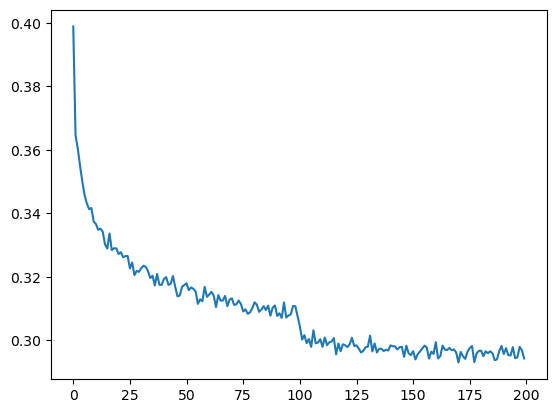

In [31]:
def trainModel(X, Y, model, n_epochs, batch_size):
  lossi = []
  ud = []
  parameters = model.parameters()

  for epoch in range(n_epochs):

    # Minibatch Construct
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = X[ix], Y[ix] # batch X, Y 

    # Forward Pass
    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)

    # Backward Pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # Update Parameters
    lr = 0.1 if epoch < 100000 else 0.01 # stop learning rate decay
    for p in parameters:
      p.data += -lr * p.grad
    
    # Track Stats
    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    if epoch % 10000 == 0:
      print(f'{epoch:7d}/{n_epochs:7d}: {loss.item():.4f}')
  
  plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
  return lossi, ud, parameters

lossi, ud, parameters = trainModel(Xtr, Ytr, model, N_EPOCHS, BATCH_SIZE)

In [32]:
@torch.no_grad()
def loss(X, Y, model):
  for layer in model.layers:
    layer.training = False
  logits = model(X)
  loss = F.cross_entropy(logits, Y)
  return loss

In [33]:
print(f'Train Loss: {loss(Xtr, Ytr, model)}')
print(f'Val Loss: {loss(Xdev, Ydev, model)}')

Train Loss: 1.9494009017944336
Val Loss: 2.0295262336730957


In [34]:
def generateExample(model, block_size, itos):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  return ''.join(itos[i] for i in out)

def generateExamples(model, block_size, itos, numExamples = 20):
  for layer in model.layers:
    layer.training = False
  examples = []
  for _ in range(numExamples):
    example = generateExample(model, block_size, itos)
    examples.append(example)
  return examples

In [35]:
examples = generateExamples(model, BLOCK_SIZE, itos)
print(f'Generated Examples: {examples}')

Generated Examples: ['braxgi.', 'noet.', 'lakin.', 'rhil.', 'maklaud.', 'trissa.', 'olinn.', 'tebela.', 'telin.', 'junep.', 'maris.', 'isandry.', 'jam.', 'phrazber.', 'lauriza.', 'kisca.', 'alex.', 'ohavanmia.', 'jeylis.', 'shamanie.']
